In [2]:
## imports
from qiskit import *
from qiskit.algorithms import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import quantum_info, IBMQ, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit.extensions import HamiltonianGate
# backend = BasicAer.get_backend("statevector_simulator")
# quantum_instance = QuantumInstance(backend)
from qiskit.algorithms import AmplitudeEstimation
from qiskit.quantum_info import Statevector, Operator
from qiskit.opflow import CircuitStateFn
#from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector
import numpy as np
import scipy 
from numpy import pi
import seaborn as sns
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt

In [3]:
## import optimisers
from qiskit.algorithms.optimizers import COBYLA
from scipy.optimize import minimize

In [4]:
# setup simulators using IBM_id
# IBMQ.save_account("1c62e8a0d2b058d0e797db9c811bc34582df5553e25812301cd1518662c0ab68d2378ac6c197b65f8be944d04b7e7439f034e3926a44fa8088538b3d13782c1a", overwrite= True)
provider = IBMQ.load_account()
IBMQ.get_provider(hub='ibm-q-education', group='iit-madras-1', project='quantum-computin')
# setup required backends 
lima = provider.get_backend('ibmq_lima')
manila = provider.get_backend('ibmq_manila')
qsm = Aer.get_backend('qasm_simulator')
stv = Aer.get_backend('statevector_simulator')
aer = Aer.get_backend('aer_simulator')

In [5]:
## sub-routines for QFT  ~
def crot(qc, l):
    """ Function to generate Controlled Rotation Ooeration  """
    if l == 0:
        return qc
    l = l-1
    qc.h(l)
    for q in range(l):
        qc.cp(pi/2**(l-q), q, l)
    #qc.barrier()
    # qc.draw()
    
def QFT(qc):
   """function to generate QFT circuit """
   dim = qc.num_qubits
   for q in range(dim):
      crot(qc, dim-q)
   for q in range(int(dim/2)):
      qc.swap(q, dim-q-1)

   #qc.draw()
   return qc
   

## Quantum Dictionary
Implement a quantum algorithm to store (key, value) pairs in the same form a regular hash-based dictionary works. 

Given the keys $\{k_i\}$ and values $\{v_i\}$ the quantum dictionary implements a circuit to prepare the state
$$  \ket{\psi(k,v)} = \sum_{k_i} \ket{k_i}\ket{v_i}  $$


Our purpose here is to use the quantum dictionary format to store the function evaluations of the an function 'f(k)' on the keys 'k',
$$  \ket{\psi(f)} = \sum_{k_i} \ket{k_i}\ket{f(k_i)} $$

### Example 1: 
There's a function 
'f(x)'such that
$$ f(0) = 5, f(3) = 7
$$

In [6]:
precision = 3
qreg = QuantumRegister(2, name= 'qreg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_q = ClassicalRegister(2, name='creg')
creg_qm = ClassicalRegister(precision, name= 'precision_c')

qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_q)

qc.h(qreg)
qc.h(qm)
qc.rx(pi/2, ancilla)
qc.z(ancilla)
qc.x(ancilla)
qc.barrier()

# qc.x(qreg[0])
# qc.mcry(  4*(2*pi/2**4)*2, [qreg[0],qm[0]],ancilla)
# qc.mcry(  4*(2*pi/2**4)*2, [qreg[0],qreg[1],qm[0]],ancilla)
# qc.mcry(  1*(2*pi/2**4)*2, [qreg[1],qm[0]],ancilla)
qc.x(qreg)
qc.mcry(5*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
qc.mcry(5*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
qc.mcry(5*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)
qc.x(qreg)

# qc.x(qreg)
qc.mcry(7*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
qc.mcry(7*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
qc.mcry(7*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)
# qc.x(qreg)


qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , [2,3,4]  )
qc.barrier()
# qc.draw()




In [7]:
qc.measure(qreg, creg_q )
qc.measure(qm, creg_qm)
# qc.draw()


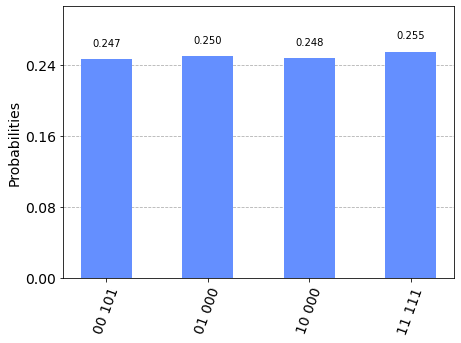

In [8]:
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)

#### Example 2:
Function 'f(x)' defined on 3 variables as :

$$  f(x_1, x_2, x_3) = -2 x_1 x_2 + 3 x_1 x_3 - x_1   $$

In [9]:
precision = 3
qreg = QuantumRegister(3, name= 'qreg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_q = ClassicalRegister(3, name='creg')
creg_qm = ClassicalRegister(precision, name= 'precision_c')

qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_q)

qc.h(qreg)
qc.h(qm)
qc.rx(pi/2, ancilla)
qc.z(ancilla)
qc.x(ancilla)
qc.barrier()



qc.mcry(-2*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
qc.mcry(-2*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
qc.mcry(-2*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)

qc.mcry(-1*(2*pi/2**precision)*2, [qreg[0],  qm[0]], ancilla)
qc.mcry(-1*(2*pi/2**precision)*4, [qreg[0],  qm[1]], ancilla)
qc.mcry(-1*(2*pi/2**precision)*8, [qreg[0],  qm[2]], ancilla)

qc.mcry(3*(2*pi/2**precision)*2, [qreg[0], qreg[2], qm[0]], ancilla)
qc.mcry(3*(2*pi/2**precision)*4, [qreg[0], qreg[2], qm[1]], ancilla)
qc.mcry(3*(2*pi/2**precision)*8, [qreg[0], qreg[2], qm[2]], ancilla)



qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , qm  )

qc.x(ancilla)
qc.z(ancilla)
qc.rx(pi/2, ancilla)


qc.barrier()
# qc.draw()




In [10]:
qc.measure(qreg, creg_q )
qc.measure(qm, creg_qm)
# qc.draw()

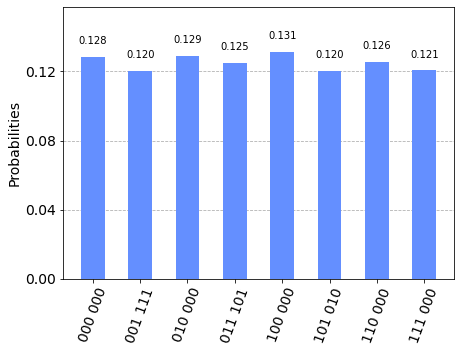

In [11]:
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)
# counts

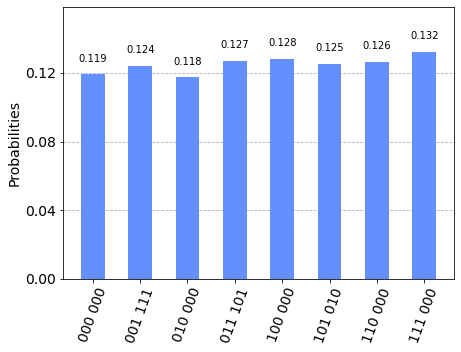

In [12]:
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)
# counts

#### Example 3 :

Follows from the last exmaple, we use a post processing layer of grover operators to amplify the states with negative 'values' of f(x) i.e the oracle would amplify states like $\ket{f(x)}$ where $f(x) \leq 0$.

In [13]:
## grover operator for conditioning amplification of negative values of the function evaluation
def grover(function_dictionary,val_q, precision  ,steps ):
    """ Return the grover operator that amplifies 'flag_state' amplitudes 
        ARGS:
            function_dictionary= QuantumCircuit to prepare the quantum dictionary whihc takes argument 
                                 val_q, precision, i.e function_dictionary(val_q, precision)                       
            steps= no. of grover steps
        RETURNS:
            QuantumCircuit
    """
    ## initialisation
    qreg = QuantumRegister(val_q, name= 'f_reg')
    qm = QuantumRegister(precision, name= 'precision')
    ancilla = QuantumRegister(1, name= 'ancilla')
    creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
    creg_qm = ClassicalRegister(precision, name= 'precision_c')
    qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
    f_eval = function_dictionary(val_q, precision)

    ## oracle sub rouitne
    qc.x(ancilla)
    qc.h(ancilla)
    qc.cx(qm[-1] , ancilla)
    qc.h(ancilla)
    qc.x(ancilla)

    ## diffuser sub routine 
    qc = qc.compose(function_dictionary(val_q, precision).to_gate().inverse())
    qc.x(ancilla)
    qc.h(ancilla)    
    qc.x(qreg)
    qc.x(qm)
    qc.mcx(qc._qubits[:-1], ancilla) 
    qc.x(qm)
    qc.x(qreg)
    qc.h(ancilla)
    qc.x(ancilla)
    qc = qc.compose(function_dictionary(val_q, precision).to_gate())

    return qc


    

In [14]:
def create_function_dictionary(val_q, precision, ):
    ## todo: add generalizability for arbitrary polynomial
    """ Returns a circuit implementing quantum-dictionary for a certain function
        ARGS:
            val_q= no. of qubits for thhhe function 'key'
            precision= no. of qubits required for the function 'value'
        RETURNS: 
            QuantumCircuit
    """
    precision = 3
    qreg = QuantumRegister(3, name= 'qreg')
    qm = QuantumRegister(precision, name= 'precision')
    ancilla = QuantumRegister(1, name= 'ancilla')
    # creg_q = ClassicalRegister(3, name='creg')
    # creg_qm = ClassicalRegister(precision, name= 'precision_c')

    qc = QuantumCircuit(qreg, qm, ancilla, name= 'qdic_f')

    qc.h(qreg)
    qc.h(qm)

    qc.rx(pi/2, ancilla)
    qc.z(ancilla)
    qc.x(ancilla)

    # qc.barrier()

    qc.mcry(-2*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
    qc.mcry(-2*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
    qc.mcry(-2*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)

    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[0],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[0],  qm[1]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*8, [qreg[0],  qm[2]], ancilla)

    qc.mcry(3*(2*pi/2**precision)*2, [qreg[0], qreg[2], qm[0]], ancilla)
    qc.mcry(3*(2*pi/2**precision)*4, [qreg[0], qreg[2], qm[1]], ancilla)
    qc.mcry(3*(2*pi/2**precision)*8, [qreg[0], qreg[2], qm[2]], ancilla)

    # qc.barrier()

    qc.x(ancilla)
    qc.z(ancilla)
    qc.rx(-pi/2, ancilla)


    qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , qm  )
    
    return qc



In [15]:
precision = 3
val_q =3
qreg = QuantumRegister(val_q, name= 'f_reg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
creg_qm = ClassicalRegister(precision, name= 'precision_c')
qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
qc = qc.compose(create_function_dictionary(val_q, precision).to_gate() )

# qc.draw()

measurement without amplification

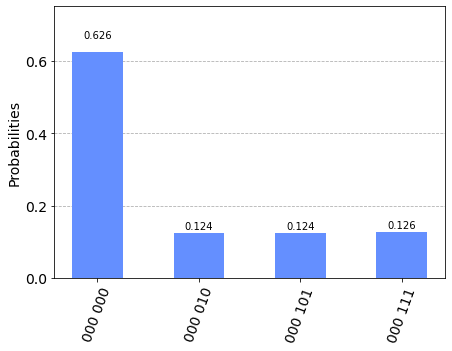

In [16]:
## measurement without amplification
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)

In [17]:
f_dic = create_function_dictionary(val_q, precision)
qc.compose(grover(f_dic,val_q, precision,1))
# ## oracle sub rouitne
# qc.x(ancilla)
# qc.h(ancilla)
# qc.cx(qm[-1] , ancilla)
# qc.h(ancilla)
# qc.x(ancilla)

# ## diffuser sub routine 
# qc = qc.compose(function_dictionary(val_q, precision).to_gate().inverse())
# qc.x(ancilla)
# qc.h(ancilla)    
# qc.x(qreg)
# qc.x(qm)
# qc.mcx(qc._qubits[:-1], ancilla) 
# qc.x(qm)
# qc.x(qreg)
# qc.h(ancilla)
# qc.x(ancilla)
# qc = qc.compose(function_dictionary(val_q, precision).to_gate())

qc.draw()

TypeError: 'QuantumCircuit' object is not callable

 measurment with amplification of state with f(x) < 0 

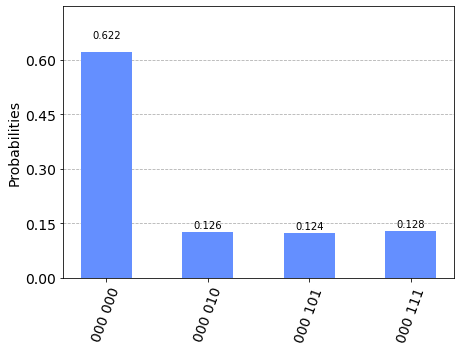

In [18]:
# qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)
# counts

Since the key-value pairs are entanngled we can easily recognise the keys 'x' corresponding to values of 'f(x)' with f(x) < 0.

### QUBO using quantum dictionary

#### 1. Max-cut problem with fully-connected three nodes.

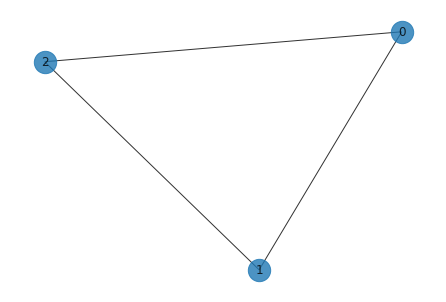

In [19]:
graph = nx.Graph()
graph.add_nodes_from([0,1,2])
graph.add_edges_from([(0,1),(0,2),(2,1)])

nx.draw(graph, with_labels= True, alpha= 0.8, node_size= 500)

The corresponding QUBO objective function is 
$$  f(x_0, x_1, x_2) = -( x_0 + x_1 + x_2 - x_0 x_1 - x_1 x_2 - x_2 x_0 )
$$

In [20]:
def create_function_dictionary_maxcut(val_q, precision, ):
    ## todo: add generalizability for arbitrary polynomial
    """ Returns a circuit implementing quantum-dictionary for a certain function
        ARGS:
            val_q= no. of qubits for thhhe function 'key'
            precision= no. of qubits required for the function 'value'
        RETURNS: 
            QuantumCircuit
    """
    precision = 2
    qreg = QuantumRegister(3, name= 'qreg')
    qm = QuantumRegister(precision, name= 'precision')
    ancilla = QuantumRegister(1, name= 'ancilla')
    # creg_q = ClassicalRegister(3, name='creg')
    # creg_qm = ClassicalRegister(precision, name= 'precision_c')

    qc = QuantumCircuit(qreg, qm, ancilla, name= 'qdic_f')

    qc.h(qreg)
    qc.h(qm)

    qc.rx(pi/2, ancilla)
    qc.z(ancilla)
    qc.x(ancilla)

    # qc.barrier()


    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[0],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[0],  qm[1]], ancilla)
    # qc.mcry(-1*(2*pi/2**precision)*8, [qreg[0],  qm[2]], ancilla)

    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[1],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[1],  qm[1]], ancilla)
    # qc.mcry(-1*(2*pi/2**precision)*8, [qreg[1],  qm[2]], ancilla)

    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[2],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[2],  qm[1]], ancilla)
    # qc.mcry(-1*(2*pi/2**precision)*8, [qreg[2],  qm[2]], ancilla)

    qc.mcry(+1*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
    qc.mcry(+1*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
    # qc.mcry(+1*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)

    qc.mcry(+1*(2*pi/2**precision)*2, [qreg[2], qreg[1], qm[0]], ancilla)
    qc.mcry(+1*(2*pi/2**precision)*4, [qreg[2], qreg[1], qm[1]], ancilla)
    # qc.mcry(+1*(2*pi/2**precision)*8, [qreg[2], qreg[1], qm[2]], ancilla)

    qc.mcry(+1*(2*pi/2**precision)*2, [qreg[0], qreg[2], qm[0]], ancilla)
    qc.mcry(+1*(2*pi/2**precision)*4, [qreg[0], qreg[2], qm[1]], ancilla)
    # qc.mcry(+1*(2*pi/2**precision)*8, [qreg[0], qreg[2], qm[2]], ancilla)

    # qc.barrier()

    qc.x(ancilla)
    qc.z(ancilla)
    qc.rx(-pi/2, ancilla)


    qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , qm  )
    
    return qc



In [21]:
precision = 2
val_q =3
qreg = QuantumRegister(val_q, name= 'f_reg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
creg_qm = ClassicalRegister(precision, name= 'precision_c')
qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
qc = qc.compose(create_function_dictionary_maxcut(val_q, precision).to_gate() )
qc.barrier()
qc.draw()

┌─────────┐ ░ 
      f_reg_0: ┤0        ├─░─
               │         │ ░ 
      f_reg_1: ┤1        ├─░─
               │         │ ░ 
      f_reg_2: ┤2        ├─░─
               │  qdic_f │ ░ 
  precision_0: ┤3        ├─░─
               │         │ ░ 
  precision_1: ┤4        ├─░─
               │         │ ░ 
      ancilla: ┤5        ├─░─
               └─────────┘ ░ 
precision_c: 2/══════════════
                             
    f_reg_c: 3/══════════════

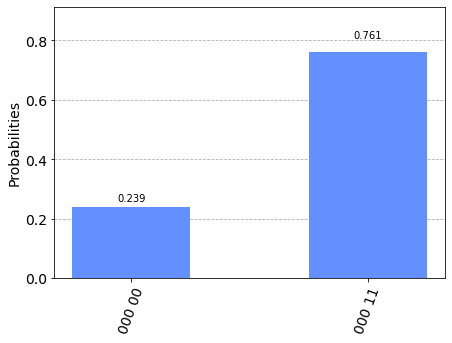

In [22]:
# qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)

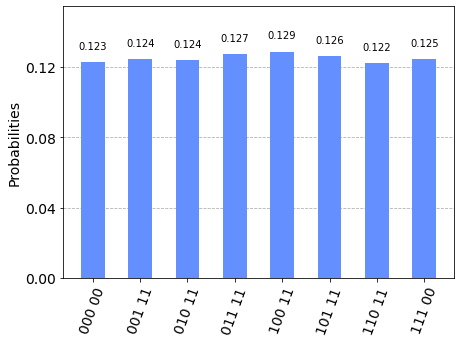

In [23]:
qc.measure(qreg, creg_qreg)
# qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)

In [24]:
steps = 1
for step in range(steps):
    ## oracle sub rouitne
    qc.x(ancilla)
    qc.h(ancilla)
    qc.cx(qm[-1] , ancilla)
    qc.h(ancilla)
    qc.x(ancilla)

    ## diffuser sub routine 
    qc = qc.compose(create_function_dictionary_maxcut(val_q, precision).to_gate().inverse())
    qc.x(ancilla)
    qc.h(ancilla)    
    qc.x(qreg)
    qc.x(qm)
    qc.mcx(qc._qubits[:-1], ancilla) 
    qc.x(qm)
    qc.x(qreg)
    qc.h(ancilla)
    qc.x(ancilla)
    qc = qc.compose(create_function_dictionary_maxcut(val_q, precision).to_gate())

qc.draw()

┌─────────┐ ░       ┌─┐                               »
      f_reg_0: ┤0        ├─░───────┤M├───────────────────────────────»
               │         │ ░       └╥┘┌─┐                            »
      f_reg_1: ┤1        ├─░────────╫─┤M├────────────────────────────»
               │         │ ░        ║ └╥┘┌─┐                         »
      f_reg_2: ┤2        ├─░────────╫──╫─┤M├─────────────────────────»
               │  qdic_f │ ░ ┌─┐    ║  ║ └╥┘                         »
  precision_0: ┤3        ├─░─┤M├────╫──╫──╫──────────────────────────»
               │         │ ░ └╥┘┌─┐ ║  ║  ║                          »
  precision_1: ┤4        ├─░──╫─┤M├─╫──╫──╫─────────────■────────────»
               │         │ ░  ║ └╥┘ ║  ║  ║ ┌───┐┌───┐┌─┴─┐┌───┐┌───┐»
      ancilla: ┤5        ├─░──╫──╫──╫──╫──╫─┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├»
               └─────────┘ ░  ║  ║  ║  ║  ║ └───┘└───┘└───┘└───┘└───┘»
precision_c: 2/═══════════════╩══╩══╬══╬══╬══════════════════════════»
                              0  1  ║  ║  ║                          »
    f_reg_c: 3/═════════════════════╩══╩══╩══════════════════════════»
                                    0  1  2                          »
«               ┌────────────┐┌───┐          ┌───┐     ┌─────────┐
«      f_reg_0: ┤0           ├┤ X ├───────■──┤ X ├─────┤0        ├
«               │            │├───┤       │  ├───┤     │         │
«      f_reg_1: ┤1           ├┤ X ├───────■──┤ X ├─────┤1        ├
«               │            │├───┤       │  ├───┤     │         │
«      f_reg_2: ┤2           ├┤ X ├───────■──┤ X ├─────┤2        ├
«               │  qdic_f_dg │├───┤       │  ├───┤     │  qdic_f │
«  precision_0: ┤3           ├┤ X ├───────■──┤ X ├─────┤3        ├
«               │            │├───┤       │  ├───┤     │         │
«  precision_1: ┤4           ├┤ X ├───────■──┤ X ├─────┤4        ├
«               │            │├───┤┌───┐┌─┴─┐├───┤┌───┐│         │
«      ancilla: ┤5           ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤5        ├
«               └────────────┘└───┘└───┘└───┘└───┘└───┘└─────────┘
«precision_c: 2/══════════════════════════════════════════════════
«                                                                 
«    f_reg_c: 3/══════════════════════════════════════════════════
«

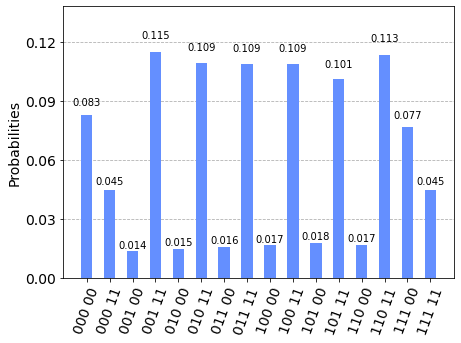

In [25]:
# qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)
# counts

#### 2. Max-Cut problem with partially-connected 3 nodes

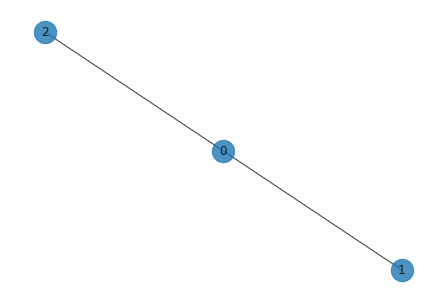

In [26]:
graph2 = nx.Graph()
graph2.add_nodes_from([0,1,2])
graph2.add_edges_from([(0,1),(0,2)])

nx.draw(graph2, with_labels= True, alpha= 0.8, node_size= 500)

In [30]:
# list(graph2.adjacency())[0]
list(graph2.edges())[0][1]

1

The QUBO objective function ofr the following problem
$$  f(x_1, x_2, x_3) = -( 2 x_0 + x_1 + x_2 - 2 x_0 x_1 - 2 x_0 x_2)
$$

In [41]:
def create_function_dictionary_maxcut_g(graph , precision, ):
    ## todo: add generalizability for arbitrary polynomial
    """ Returns a circuit implementing quantum-dictionary for a certain function
        ARGS:
            graph= networkx.Graph object for the max-cur problem
            precision= no. of qubits required for the function 'value'
        RETURNS: 
            QuantumCircuit
    """
    num_qbit = graph.number_of_nodes()
    # precision = 2
    qreg = QuantumRegister(num_qbit, name= 'qreg')
    qm = QuantumRegister(precision, name= 'precision')
    ancilla = QuantumRegister(1, name= 'ancilla')
    # creg_q = ClassicalRegister(3, name='creg')
    # creg_qm = ClassicalRegister(precision, name= 'precision_c')

    qc = QuantumCircuit(qreg, qm, ancilla, name= 'qdic_f')

    qc.h(qreg)
    qc.h(qm)

    qc.rx(pi/2, ancilla)
    qc.z(ancilla)
    qc.x(ancilla)

    # qc.barrier()

    for edge in list(graph.edges) :
        node0, node1 = edge[0], edge[1]
        for index in range(precision) :
            qc.mcry(-1*(2*pi/2**precision)*2*(2**index), [qreg[node0],  qm[index]], ancilla)
        for index in range(precision) :
            qc.mcry(-1*(2*pi/2**precision)*2*(2**index), [qreg[node1],  qm[index]], ancilla) 
        for index in range(precision) :
            qc.mcry(+2*(2*pi/2**precision)*2*(2**index), [qreg[node0], qreg[node1], qm[index]], ancilla)                   

    # qc.barrier()

    qc.x(ancilla)
    qc.z(ancilla)
    qc.rx(-pi/2, ancilla)


    qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , qm  )
    
    return qc



In [51]:
precision = 2
val_q = 3
qreg = QuantumRegister(val_q, name= 'f_reg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
creg_qm = ClassicalRegister(precision, name= 'precision_c')
qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
qc = qc.compose(create_function_dictionary_maxcut_g(graph2, precision).to_gate() )
qc.barrier()

# qc.draw()

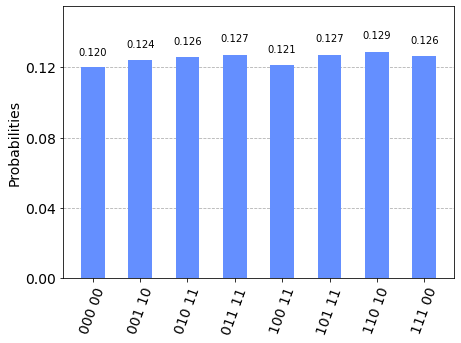

In [52]:
qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)


In [35]:
def create_function_dictionary_maxcut_o(val_q, precision, ):
    ## todo: add generalizability for arbitrary polynomial
    """ Returns a circuit implementing quantum-dictionary for a certain function
        ARGS:
            val_q= no. of qubits for thhhe function 'key'
            precision= no. of qubits required for the function 'value'
        RETURNS: 
            QuantumCircuit
    """
    # precision = 2
    qreg = QuantumRegister(3, name= 'qreg')
    qm = QuantumRegister(precision, name= 'precision')
    ancilla = QuantumRegister(1, name= 'ancilla')
    # creg_q = ClassicalRegister(3, name='creg')
    # creg_qm = ClassicalRegister(precision, name= 'precision_c')

    qc = QuantumCircuit(qreg, qm, ancilla, name= 'qdic_f')

    qc.h(qreg)
    qc.h(qm)

    qc.rx(pi/2, ancilla)
    qc.z(ancilla)
    qc.x(ancilla)

    # qc.barrier()


    qc.mcry(-2*(2*pi/2**precision)*2, [qreg[0],  qm[0]], ancilla)
    qc.mcry(-2*(2*pi/2**precision)*4, [qreg[0],  qm[1]], ancilla)
    qc.mcry(-2*(2*pi/2**precision)*8, [qreg[0],  qm[2]], ancilla)

    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[1],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[1],  qm[1]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*8, [qreg[1],  qm[2]], ancilla)

    qc.mcry(-1*(2*pi/2**precision)*2, [qreg[2],  qm[0]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*4, [qreg[2],  qm[1]], ancilla)
    qc.mcry(-1*(2*pi/2**precision)*8, [qreg[2],  qm[2]], ancilla)

    qc.mcry(+2*(2*pi/2**precision)*2, [qreg[0], qreg[1], qm[0]], ancilla)
    qc.mcry(+2*(2*pi/2**precision)*4, [qreg[0], qreg[1], qm[1]], ancilla)
    qc.mcry(+2*(2*pi/2**precision)*8, [qreg[0], qreg[1], qm[2]], ancilla)

    # qc.mcry(+1*(2*pi/2**precision)*2, [qreg[2], qreg[1], qm[0]], ancilla)
    # qc.mcry(+1*(2*pi/2**precision)*4, [qreg[2], qreg[1], qm[1]], ancilla)
    # qc.mcry(+1*(2*pi/2**precision)*8, [qreg[2], qreg[1], qm[2]], ancilla)

    qc.mcry(+2*(2*pi/2**precision)*2, [qreg[0], qreg[2], qm[0]], ancilla)
    qc.mcry(+2*(2*pi/2**precision)*4, [qreg[0], qreg[2], qm[1]], ancilla)
    qc.mcry(+2*(2*pi/2**precision)*8, [qreg[0], qreg[2], qm[2]], ancilla)

    # qc.barrier()

    qc.x(ancilla)
    qc.z(ancilla)
    qc.rx(-pi/2, ancilla)


    qc = qc.compose(QFT(QuantumCircuit(precision, name= 'QFT')).to_gate().inverse() , qm  )
    
    return qc



In [ ]:
precision = 3
val_q = 3
qreg = QuantumRegister(val_q, name= 'f_reg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
creg_qm = ClassicalRegister(precision, name= 'precision_c')
qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
qc = qc.compose(create_function_dictionary_maxcut_o(val_q, precision).to_gate() )
qc.barrier()

qc.draw()

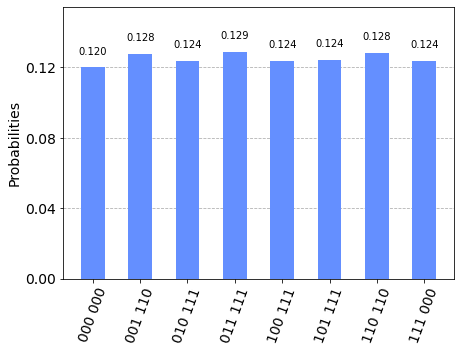

In [49]:
qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)


In [39]:
precision = 3
val_q =3
qreg = QuantumRegister(val_q, name= 'f_reg')
qm = QuantumRegister(precision, name= 'precision')
ancilla = QuantumRegister(1, name= 'ancilla')
creg_qreg = ClassicalRegister(val_q, name='f_reg_c')
creg_qm = ClassicalRegister(precision, name= 'precision_c')
qc = QuantumCircuit(qreg, qm, ancilla, creg_qm, creg_qreg)
qc = qc.compose(create_function_dictionary_maxcut_o(val_q, precision).to_gate() )
qc.barrier()

qc.draw()

steps = 3
for step in range(steps):
    ## oracle sub rouitne
    qc.x(ancilla)
    qc.h(ancilla)
    qc.cx(qm[-1] , ancilla)
    qc.h(ancilla)
    qc.x(ancilla)

    ## diffuser sub routine 
    qc = qc.compose(create_function_dictionary_maxcut(val_q, precision).to_gate().inverse())
    qc.x(ancilla)
    qc.h(ancilla)    
    qc.x(qreg)
    qc.x(qm)
    qc.mcx(qc._qubits[:-1], ancilla) 
    qc.x(qm)
    qc.x(qreg)
    qc.h(ancilla)
    qc.x(ancilla)
    qc = qc.compose(create_function_dictionary_maxcut(val_q, precision).to_gate())

# qc.draw()

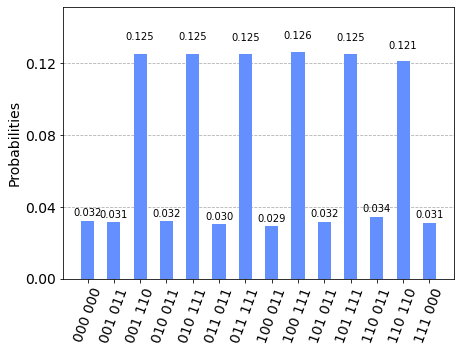

In [40]:
qc.measure(qreg, creg_qreg)
qc.measure(qm, creg_qm)
counts = execute(qc, backend= aer, shots= 10024).result().get_counts()
plot_histogram(counts)
